# **Gözetimsiz Öğrenme ile Müşteri Segmentasyonu (Customer Segmentation with Unsupervised Learning)**
##   
###   **İş Problemi (Business Problem)**
#### Unsupervised Learning yöntemleri ile (Kmeans, Hierarchical Clustering )  müşteriler kümelere ayrılarak davranışları gözlemlenmek istenmektedir.
###  **Veri Seti Hikayesi**
#### Veri seti, son alışverişlerini 2020 - 2021 yıllarında OmniChannel(hem online hem offline) olarak yapan müşterilerin geçmiş alışveriş davranışlarından elde edilen bilgilerden oluşmaktadır.
#### Toplam 20.000 gözlem, 13 değişken bulunmaktadır.
* #### **master_id:** Eşsiz müşteri numarası
* #### **order_channel :** Alışveriş yapılan platforma ait hangi kanalın kullanıldığı (Android, ios, Desktop, Mobile, Offline)
* #### **last_order_channel :** En son alışverişin yapıldığı kanal
* #### **first_order_date :** Müşterinin yaptığı ilk alışveriş tarihi
* #### **last_order_date :** Müşterinin yaptığı son alışveriş tarihi
* #### **last_order_date_online :** Muşterinin online platformda yaptığı son alışveriş tarihi
* #### **last_order_date_offline :** Muşterinin offline platformda yaptığı son alışveriş tarihi
* #### **order_num_total_ever_online :** Müşterinin online platformda yaptığı toplam alışveriş sayısı
* #### **order_num_total_ever_offline :** Müşterinin offline'da yaptığı toplam alışveriş sayısı
* #### **customer_value_total_ever_offline :** Müşterinin offline alışverişlerinde ödediği toplam ücret
* #### **customer_value_total_ever_online :** Müşterinin online alışverişlerinde ödediği toplam ücret
* #### **interested_in_categories_12 :** Müşterinin son 12 ayda alışveriş yaptığı kategorilerin listesi
* #### **store_type :** 3 farklı companyi ifade eder. A company'sinden alışveriş yapan kişi B'dende yaptı ise A,B şeklinde yazılmıştır.



#### **GÖREV 1:** Veri setini okutunuz ve müşterileri segmentlerken kullanılması gereken değişkenleri seçiniz.

In [1]:
import pandas as pd
from scipy import stats
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import numpy as np
# import os

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.width', 1000)

In [3]:
df = pd.read_csv("/kaggle/input/flo-data-set-csv/flo_data_20k.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   master_id                          19945 non-null  object 
 1   order_channel                      19945 non-null  object 
 2   last_order_channel                 19945 non-null  object 
 3   first_order_date                   19945 non-null  object 
 4   last_order_date                    19945 non-null  object 
 5   last_order_date_online             19945 non-null  object 
 6   last_order_date_offline            19945 non-null  object 
 7   order_num_total_ever_online        19945 non-null  float64
 8   order_num_total_ever_offline       19945 non-null  float64
 9   customer_value_total_ever_offline  19945 non-null  float64
 10  customer_value_total_ever_online   19945 non-null  float64
 11  interested_in_categories_12        19945 non-null  obj

In [5]:
# tarih değişkenine çevirme
date_columns = df.columns[df.columns.str.contains("date")]
df[date_columns] = df[date_columns].apply(pd.to_datetime)

In [6]:
df["last_order_date"].max()

Timestamp('2021-05-30 00:00:00')

In [7]:
# Analiz tarihi:
analysis_date = df["last_order_date"].max() + pd.Timedelta(days=2)
analysis_date

Timestamp('2021-06-01 00:00:00')

In [8]:
# recency ve tenure değişkenlerini oluşturma
df["recency"] = (analysis_date - df["last_order_date"]).dt.days
df["tenure"] = (df["last_order_date"] - df["first_order_date"]).dt.days

#### **Kullanılacak Değişkenleri Seçme**


In [9]:
df.columns


Index(['master_id', 'order_channel', 'last_order_channel', 'first_order_date', 'last_order_date', 'last_order_date_online', 'last_order_date_offline', 'order_num_total_ever_online', 'order_num_total_ever_offline', 'customer_value_total_ever_offline', 'customer_value_total_ever_online', 'interested_in_categories_12', 'recency', 'tenure'], dtype='object')

In [10]:
# Birden fazla master_id var mı? 
df['master_id'].value_counts().max()

1

In [11]:
# Tek seferlik alışverişleri mi yansıtıyor? Yoksa Arka tarafta işlemler mi yapılıyor?
df.order_channel.value_counts()


order_channel
Android App    9495
Mobile         4882
Ios App        2833
Desktop        2735
Name: count, dtype: int64

In [12]:
df.last_order_channel.value_counts()

last_order_channel
Android App    6783
Offline        6608
Mobile         3172
Ios App        1696
Desktop        1686
Name: count, dtype: int64

In [13]:
# En eski müşteri kim?
df[df['first_order_date']==df.first_order_date.min()]

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,recency,tenure
17616,1d033d3a-b090-11e9-9757-000d3a38a36f,Mobile,Desktop,2013-01-14,2021-04-18,2021-04-18,2019-12-15,49.00,2.00,329.97,4517.95,"[ERKEK, COCUK, KADIN]",44,3016


In [14]:
# last_order_channel = Offline olan müşterilerin 'order_channel' değerleri
df[df['last_order_channel'] == 'Offline'][['order_channel','last_order_channel']]


,order_channel,last_order_channel
0,Android App,Offline
5,Desktop,Offline
7,Mobile,Offline
10,Ios App,Offline
12,Mobile,Offline
...,...,...
19928,Desktop,Offline
19932,Android App,Offline
19934,Desktop,Offline
19939,Ios App,Offline


In [15]:
# model veri seti
model_df = df[["order_num_total_ever_online","order_num_total_ever_offline","customer_value_total_ever_offline","customer_value_total_ever_online","recency","tenure"]]


In [16]:
model_df.head()


,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,4.00,1.00,139.99,799.38,95,119
1,19.00,2.00,159.97,1853.58,105,1469
2,3.00,2.00,189.97,395.35,186,366
3,1.00,1.00,39.99,81.98,135,11
4,1.00,1.00,49.99,159.99,86,582


#### **GÖREV 2:** K-Means ile Müşteri Segmentasyonu


In [17]:
# 1. SKEWNESS ile değişkenleri standartlaştırma
def check_skew(df_skew, column, useLog=False):
    try:
        skew = stats.skew(df_skew[column])
        skewtest = stats.skewtest(df_skew[column])
        plt.title('Distribution of ' + column)
        
        # Checking if log scale is requested and data is strictly positive
        if useLog and (df_skew[column] > 0).all():
            sns.histplot(np.log(df_skew[column]), kde=True, color="g")
        elif useLog and not (df_skew[column] > 0).all():
            print("Data contains zero or negative values, cannot use logarithmic scale")
            sns.histplot(df_skew[column], kde=True, color="g")
        else:
            sns.histplot(df_skew[column], kde=True, color="g")
            
        print("{}'s Skew: {}, Skew Test Result: {}".format(column, skew, skewtest))
    except Exception as e:
        print(f"Error processing column {column}: {e}")

order_num_total_ever_online's Skew: 10.487693811914617, Skew Test Result: SkewtestResult(statistic=152.9996121784795, pvalue=0.0)
order_num_total_ever_offline's Skew: 20.328068075845888, Skew Test Result: SkewtestResult(statistic=184.13121810134328, pvalue=0.0)
customer_value_total_ever_offline's Skew: 16.29952194789334, Skew Test Result: SkewtestResult(statistic=173.73456097827923, pvalue=0.0)
customer_value_total_ever_online's Skew: 20.08427979804232, Skew Test Result: SkewtestResult(statistic=183.56317267711924, pvalue=0.0)
recency's Skew: 0.6172488156761073, Skew Test Result: SkewtestResult(statistic=32.86977170491703, pvalue=5.944419293752164e-237)


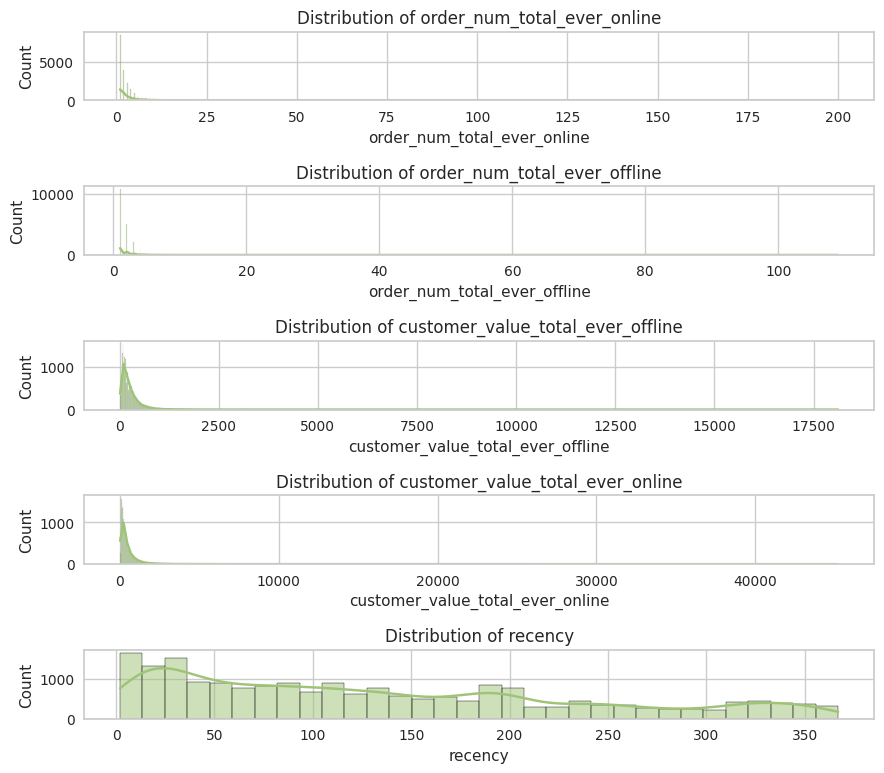

In [18]:
plt.figure(figsize=(9, 9))

plt.subplot(6, 1, 1)
check_skew(model_df,'order_num_total_ever_online')

plt.subplot(6, 1, 2)
check_skew(model_df,'order_num_total_ever_offline')

plt.subplot(6, 1, 3)
check_skew(model_df,'customer_value_total_ever_offline')

plt.subplot(6, 1, 4)
check_skew(model_df,'customer_value_total_ever_online')

plt.subplot(6, 1, 5)
check_skew(model_df,'recency')

plt.tight_layout() 
plt.show()  


In [19]:
# Normal dağılımın sağlanması için Log transformation uygulanması
def apply_log_transform(df, columns):
    """
    Apply log transformation (log1p) to specified columns of a DataFrame.

    Args:
    df (pd.DataFrame): DataFrame containing the columns to transform.
    columns (list of str): List of column names to transform.

    Returns:
    pd.DataFrame: DataFrame with the log transformations applied.
    """
    for column in columns:
        # Check if the column exists in the DataFrame
        if column in df.columns:
            # Apply np.log1p which is log(x + 1) to handle zero values safely
            df.loc[:, column] = np.log1p(df[column])
        else:
            print(f"Column '{column}' not found in DataFrame.")
    return df

In [20]:
model_df = apply_log_transform(model_df, model_df.columns)


In [21]:
model_df.head()


,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,1.61,0.69,4.95,6.69,4.56,4.79
1,3.00,1.10,5.08,7.53,4.66,7.29
2,1.39,1.10,5.25,5.98,5.23,5.91
3,0.69,0.69,3.71,4.42,4.91,2.48
4,0.69,0.69,3.93,5.08,4.47,6.37


In [22]:
# Scaling
sc = MinMaxScaler((0, 1))
model_scaling = sc.fit_transform(model_df)
model_df=pd.DataFrame(model_scaling,columns=model_df.columns)
model_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,0.20,0.00,0.34,0.50,0.72,0.60
1,0.50,0.10,0.36,0.60,0.74,0.91
2,0.15,0.10,0.39,0.41,0.86,0.74
3,0.00,0.00,0.18,0.22,0.79,0.31
4,0.00,0.00,0.21,0.30,0.70,0.79


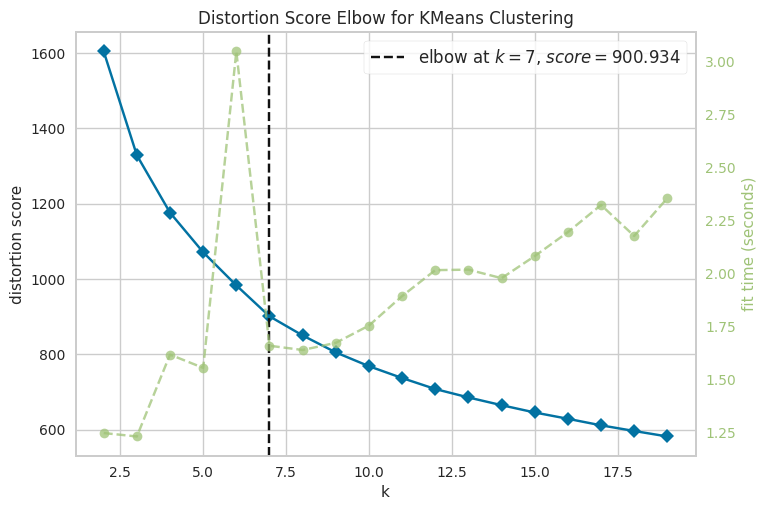

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [23]:
# 2. Optimum küme sayısını belirleme
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2, 20))
elbow.fit(model_df)
elbow.show()


In [24]:
# k-elbow değerini kullanarak optimum küme sayısını belirleme
def calculate_silhouette_scores(data, start_k, end_k, random_state=42):
    """
    Calculate K-Means clustering silhouette scores for a range of k values.

    Args:
    data (pd.DataFrame): The dataset to cluster.
    start_k (int): The starting number of clusters.
    end_k (int): The ending number of clusters (inclusive).
    random_state (int): A seed value to ensure reproducibility.

    Returns:
    dict: A dictionary of k values and their corresponding silhouette scores.
    """
    silhouette_scores = {}
    for k in range(start_k, end_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        cluster_labels = kmeans.fit_predict(data)
        score = silhouette_score(data, cluster_labels)
        silhouette_scores[k] = score
        print(f"Küme sayısı: {k}, Silhouette Skoru: {score:.2f}")
    
    return silhouette_scores

In [25]:
# Veri setiniz üzerinde 2'den 20'ye kadar silhouette skorlarını hesapla
silhouette_scores = calculate_silhouette_scores(model_df, 2, 20)

Küme sayısı: 2, Silhouette Skoru: 0.32
Küme sayısı: 3, Silhouette Skoru: 0.26
Küme sayısı: 4, Silhouette Skoru: 0.21
Küme sayısı: 5, Silhouette Skoru: 0.20
Küme sayısı: 6, Silhouette Skoru: 0.21
Küme sayısı: 7, Silhouette Skoru: 0.21
Küme sayısı: 8, Silhouette Skoru: 0.19
Küme sayısı: 9, Silhouette Skoru: 0.18
Küme sayısı: 10, Silhouette Skoru: 0.18
Küme sayısı: 11, Silhouette Skoru: 0.18
Küme sayısı: 12, Silhouette Skoru: 0.18
Küme sayısı: 13, Silhouette Skoru: 0.17
Küme sayısı: 14, Silhouette Skoru: 0.17
Küme sayısı: 15, Silhouette Skoru: 0.17
Küme sayısı: 16, Silhouette Skoru: 0.16
Küme sayısı: 17, Silhouette Skoru: 0.17
Küme sayısı: 18, Silhouette Skoru: 0.17
Küme sayısı: 19, Silhouette Skoru: 0.16
Küme sayısı: 20, Silhouette Skoru: 0.16


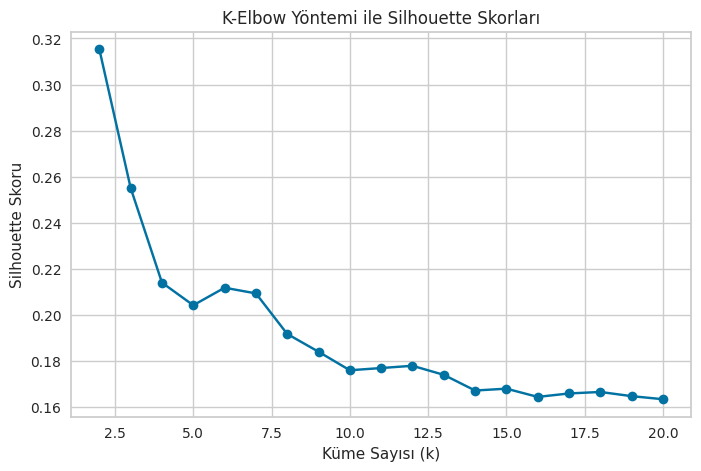

In [26]:
# k-elbow yöntemi ile silhouette_scores çizimi
plt.figure(figsize=(8, 5))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o')
plt.xlabel('Küme Sayısı (k)')
plt.ylabel('Silhouette Skoru')
plt.title('K-Elbow Yöntemi ile Silhouette Skorları')
plt.show()

In [27]:
# 3. Model  oluşturma ve müşteri segmentlerini belirleme 
k_means = KMeans(n_clusters = 7, random_state= 42).fit(model_df)
segments=k_means.labels_
segments

array([6, 6, 6, ..., 1, 2, 0], dtype=int32)

In [28]:
final_df = df[["master_id","order_num_total_ever_online","order_num_total_ever_offline","customer_value_total_ever_offline","customer_value_total_ever_online","recency","tenure"]]
final_df = final_df.copy()  # Uyarıyı kapatmak için kopya oluştur.
final_df["segment"] = segments

final_df.head()

,master_id,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure,segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,4.00,1.00,139.99,799.38,95,119,6
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,19.00,2.00,159.97,1853.58,105,1469,6
2,69b69676-1a40-11ea-941b-000d3a38a36f,3.00,2.00,189.97,395.35,186,366,6
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.00,1.00,39.99,81.98,135,11,3
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,1.00,1.00,49.99,159.99,86,582,4


In [29]:
# 4. Her bir segmenti istatistiksel olarak inceleyeniz.
final_df.groupby("segment").agg({"order_num_total_ever_online":["mean","min","max"],
                                  "order_num_total_ever_offline":["mean","min","max"],
                                  "customer_value_total_ever_offline":["mean","min","max"],
                                  "customer_value_total_ever_online":["mean","min","max"],
                                  "recency":["mean","min","max"],
                                  "tenure":["mean","min","max","count"]})

order_num_total_ever_online             order_num_total_ever_offline             customer_value_total_ever_offline                 customer_value_total_ever_online                 recency          tenure                
                               mean  min    max                         mean  min    max                              mean    min      max                             mean    min      max    mean min  max   mean min   max count
segment                                                                                                                                                                                                                            
0                              1.42 1.00   5.00                         1.28 1.00   5.00                            145.16  10.00   829.98                           210.07  12.99  1519.17  225.71  88  367 489.85  52  2820  5448
1                              2.20 1.00  12.00                         2.10 1.00  14.00                            293.82  12.99  3425.14                           377.70  23.99  3444.08   10.00   2   27 665.01   2  3031  1841
2                              1.84 1.00  13.00                         3.77 1.00 109.00                            551.78 106.82 18119.14                           283.36  14.99  2587.20  153.29  22  366 729.95  20  2911  3269
3                              1.40 1.00   8.00                         1.13 1.00   6.00                            192.39  12.99  1333.00                           250.37  19.99  3476.81  139.55   4  367  37.24   0   132   828
4                              1.61 1.00   6.00                         1.48 1.00   6.00                            185.84  12.99  1406.85                           250.00  14.00  1307.33   50.33  15  109 604.52  43  2828  3340
5                              8.63 2.00 200.00                         2.10 1.00  36.00                            278.89  12.99  3589.65                          1475.52 265.97 45220.13   32.72   2  109 966.63  18  3034  1974
6                              6.37 1.00  55.00                         1.54 1.00  16.00                            184.41  10.49  1644.79                           985.51 180.96 12038.18  180.09  55  367 943.90  26  2964  3245

#### **GÖREV 3:** Hierarchical Clustering ile Müşteri Segmentasyonu


In [30]:
# 1. Görev 2'de standarlaştırılan dataframe'i kullanarak optimum küme sayısını belirleyiniz.
hc_complete = linkage(model_df, 'complete')

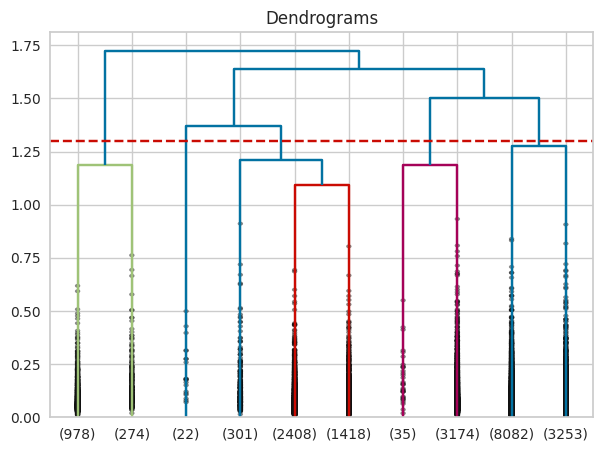

In [31]:
plt.figure(figsize=(7, 5))
plt.title("Dendrograms")
dend = dendrogram(hc_complete,
           truncate_mode="lastp",
           p=10,
           show_contracted=True,
           leaf_font_size=10)
plt.axhline(y=1.3, color='r', linestyle='--')
plt.show()

In [32]:
# 2. Modelinizi oluşturunuz ve müşterileriniz segmentleyiniz.
hc = AgglomerativeClustering(n_clusters=5)
segments = hc.fit_predict(model_df)

In [33]:
final_df = df[["master_id","order_num_total_ever_online","order_num_total_ever_offline","customer_value_total_ever_offline","customer_value_total_ever_online","recency","tenure"]]
final_df = final_df.copy()
final_df["segment"] = segments
final_df.head()

,master_id,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure,segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,4.00,1.00,139.99,799.38,95,119,3
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,19.00,2.00,159.97,1853.58,105,1469,2
2,69b69676-1a40-11ea-941b-000d3a38a36f,3.00,2.00,189.97,395.35,186,366,0
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.00,1.00,39.99,81.98,135,11,3
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,1.00,1.00,49.99,159.99,86,582,0


In [34]:
# 3. Herbir segmenti istatistiksel olarak inceleyeniz.
final_df.groupby("segment").agg({"order_num_total_ever_online":["mean","min","max"],
                                  "order_num_total_ever_offline":["mean","min","max"],
                                  "customer_value_total_ever_offline":["mean","min","max"],
                                  "customer_value_total_ever_online":["mean","min","max"],
                                  "recency":["mean","min","max"],
                                  "tenure":["mean","min","max","count"]})


order_num_total_ever_online             order_num_total_ever_offline             customer_value_total_ever_offline                customer_value_total_ever_online                 recency          tenure                 
                               mean  min    max                         mean  min    max                              mean   min      max                             mean    min      max    mean min  max   mean  min   max count
segment                                                                                                                                                                                                                            
0                              1.37 1.00  13.00                         1.99 1.00 109.00                            261.97 10.49 18119.14                           208.07  12.99 30688.47  183.03  18  367 569.72    3  2911  8747
1                              3.75 1.00  49.00                         1.82 1.00  24.00                            240.98 12.99  3425.14                           638.61  19.99 12545.37   23.96   2  108 715.07   18  3034  4994
2                              6.91 1.00 200.00                         3.08 1.00  16.00                            427.12 12.99  2963.24                          1104.12 139.98 45220.13  131.57  14  365 914.49  109  3016  2396
3                              1.40 1.00   6.00                         1.20 1.00   6.00                            200.69 12.99  1019.97                           227.42  26.99  1389.60   92.52   4  367  80.26    0   555   985
4                              4.74 1.00  24.00                         1.12 1.00   4.00                            123.46 10.00  1049.92                           722.77  59.98  7665.28  196.52  36  367 876.95   71  2964  2823